# Spike count statistics

> Raster plot

One plot of 20 simulations:
> Firing rates

> CV of ISI

> Synchrony

One boxplot for 1 simulation:
> Single neuron firing rates

> Single neuron CV of ISI

Further:
> Spike count distribution

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
#import network_params; reload(network_params)
import model_class; reload(model_class)
import sim_params as sim; reload(sim)
%matplotlib inline

show_fig = False
save_fig = True
plt.rcParams['figure.subplot.bottom'] =  0.25    # the bottom of the subplots of the figure
plt.rcParams['figure.subplot.top'] =  0.75    # the bottom of the subplots of the figure#figure.subplot.top     : 0.9    # the top of the subplots of the figure

figure_path = os.path.join(".", "figures")
reverse_order = True
colors = style.colors

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 2 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


### Raster plot

Prepare raster plot data

In [2]:
def raster_plot_results(sim_spec="raster_plot", reverse_order=True):
    data_path   = "/export/data-schuessler/data_microcircuit/micro"
    data_file_name  = sim_spec + ".hdf5"  
    path_data_file  = os.path.join(data_path, data_file_name)
    res_file_name   = sim_spec + "_res.hdf5"
    path_res_file   = os.path.join(data_path, res_file_name)

    with h5py.File(path_data_file, "r") as data_file:
        # Simulation attributes
        t_sim   = data_file.attrs["t_sim"]  
        t_trans = data_file.attrs["t_trans"]
        dt      = data_file.attrs["dt"]    
        populations   = data_file.attrs["populations"].astype("|U4")   
        n_populations = data_file.attrs["n_populations"]
        n_layers      = data_file.attrs["n_layers"]       
        n_types       = data_file.attrs["n_types"]

        grp = data_file["0/spikes"]
        dt = grp.attrs["dt"]
        n_neurons_rec_spike = grp.attrs["n_neurons_rec_spike"][:]

        t_measure = t_sim - t_trans

        if reverse_order: # Reverse the order
            offsets = np.append([0], np.cumsum(n_neurons_rec_spike[::-1]))
        else:
            offsets = np.append([0], np.cumsum(n_neurons_rec_spike))

        with h5py.File(path_res_file, "w") as  res_file:
            # Pass data to res_file:
            res_file.attrs["area"]             = data_file.attrs["area"]   
            res_file.attrs["t_sim"]            = data_file.attrs["t_sim"]  
            res_file.attrs["t_trans"]          = data_file.attrs["t_trans"]
            res_file.attrs["dt"]               = data_file.attrs["dt"]    
            res_file.attrs["populations"]      = data_file.attrs["populations"]
            res_file.attrs["layers"]           = data_file.attrs["layers"]       
            res_file.attrs["types"]            = data_file.attrs["types"]     
            res_file.attrs["n_populations"]    = data_file.attrs["n_populations"]
            res_file.attrs["n_layers"]         = data_file.attrs["n_layers"]       
            res_file.attrs["n_types"]          = data_file.attrs["n_types"] 

            for i, population in enumerate(populations):
                # Get data
                subgrp = grp[str(population)]
                raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
                indices         = subgrp["rec_neuron_i"][:]

                # Create results subgroup
                res_raster_pop = res_file.create_group(str(population))

                rnd_js = np.random.permutation(n_neurons_rec_spike[i])
                for j in range(n_neurons_rec_spike[i]):
                    times = raw_times_all[indices[j]:indices[j+1]]
                    times = times[times > t_trans]

                    if reverse_order:
                        neuron_ids_raster   = [-rnd_js[j]]*len(times) + offsets[::-1][i]
                    else:
                        neuron_ids_raster   = [rnd_js[j]]*len(times) + offsets[i]
                    raster_data         = np.vstack((times, neuron_ids_raster))
                    res_raster_pop.create_dataset(str(j), data=raster_data)

            res_file.attrs["ymax_raster"] = offsets[-1]
            res_file.attrs["yticks"] = (offsets[1:] - offsets[:-1]) * 0.5 + offsets[:-1]
            res_file.attrs["n_neurons_rec_spike"] = n_neurons_rec_spike

In [3]:
def plot_raster(ax, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    with h5py.File(path_res_file, "r") as res_raster:
        ymax_raster = res_raster.attrs["ymax_raster"]
        yticks = res_raster.attrs["yticks"]

        for i, population in enumerate(populations):
            res_raster_pop = res_raster[str(population)]
            for times, neuron_ids in res_raster_pop.values():
                ax.plot(times * 1e3 - 100, neuron_ids, ',', ms=2, color=colors[i])              

    # Raster Plot
    yticks[2] = yticks[2] * 0.95
    yticks[3] = yticks[3] * 1.05
    
    xlim = (t_trans * 1e3 - 100, t_sim * 1e3 - 100) 
    ylim = (0, ymax_raster)
    xticks = np.linspace(0, 400, 5)
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Simulation time / ms')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

save figure to raster_plot


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


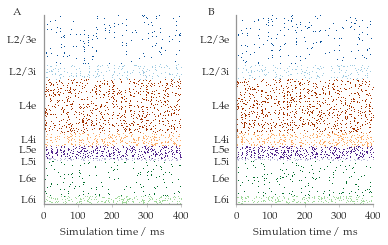

In [4]:
fig = plt.figure()
fig.set_size_inches(*style.figsize) 
ax0 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
plot_labels = list("AB")

for ax, sli, plot_label in zip(fig.axes, [False, True], plot_labels):
    data_path = "/export/data-schuessler/data_microcircuit/micro"
    raster_sim_spec = "raster_plot"
    if sli:
        raster_sim_spec += "_sli"
    #raster_plot_results(sim_spec=raster_sim_spec, reverse_order=reverse_order) # produces results file
    res_file_name = raster_sim_spec + "_res.hdf5"
    path_res_file = os.path.join(data_path, res_file_name)

    plot_raster(ax, path_res_file)

    # General rendering
    style.fixticks(ax)
    ax.yaxis.set_ticks_position('none') 

    # Label subfigures
    ax.text(-0.16, 1.04, plot_label, transform=ax.transAxes,
            fontsize=style.fontsize_plotlabel, fontweight='bold', va='top', ha='right')  

fig_name = "raster_plot"
if save_fig:
    print("save figure to " + fig_name) 
    fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), bbox_inches='tight', format="pdf")
    fig.savefig(os.path.join(figure_path, fig_name + ".png"), bbox_inches='tight', format="png")  

## Box plots for mean firing rates, mean CV of ISI, synchrony

### Boxplot

In [5]:
def box_plot(ax, data, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    """Data has to be in the right order (will not be reversed)"""
    
    boxprops = dict(linewidth=0.5, color=style.text_color)
    flierprops  = dict(marker='+', markersize=style.cross_size*0.5,
                      linestyle='None', mew=0.5)
    medianprops = dict(color=style.text_color, linewidth=0.5)
    meanprops  = dict(marker='*', markersize=4, 
                      mec='0.95', #style.text_color, 
                      markerfacecolor='0.95', #style.text_color,
                      linestyle='None', mew=0.5)

    
    box = ax.boxplot(data,
                     vert=False, showfliers=True, showmeans=True,
                     boxprops=boxprops,
                     flierprops=flierprops, medianprops=medianprops,
                     meanprops=meanprops,
                     patch_artist=True)

    if reverse_order:
        box_colors = colors[::-1]
    else:
        box_colors = colors[:]        

    for i, population in enumerate(populations):
        box["boxes"][i].set_alpha(0.8)
        box["boxes"][i].set_facecolor(box_colors[i])
        #box["boxes"][i].set_color(box_colors[i])
        box["fliers"][i].set_color(box_colors[i])
        box["whiskers"][2*i].set_color(box_colors[i])
        box["whiskers"][2*i+1].set_color(box_colors[i])
        box["caps"][2*i].set_color(box_colors[i])
        box["caps"][2*i+1].set_color(box_colors[i])

    yticks = np.arange(n_types * 0.75, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations + 1.0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)   

## Plotting rates, CV of ISI and synchrony

### Statistic of 20 simulations

In [6]:
def plot_data_cross(ax, path_res_file, 
                  data_type="rates_mean", 
                  xlabel="Mean single neuron firing rates / Hz", 
                  reverse_order=True):
    """Plot means of rates, CV of ISI or synchrony.
    Plots results of n simulations in a box plot
    Default is firing rates.
    """
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    with h5py.File(path_res_file, "r") as res_file:
        n_runs = len(res_file.keys())
        data = np.zeros((n_runs, n_populations))
        for i_run in range(n_runs):
            res_grp = res_file[str(i_run)]
            data[i_run] = res_grp[data_type][:]            
    
    ys = np.arange(n_populations) + 0.5
    if reverse_order:
        ys = ys[::-1]
    for i, population in enumerate(populations):
        ax.plot(data[:, i], [ys[i]]*n_runs, "+", color=colors[i], mew=0.8, ms=style.cross_size)

    yticks = np.arange(n_types * 0.5, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations)
    
    ax.set_xlabel(xlabel)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)

In [7]:
def plot_data_box(ax, path_res_file, 
                  data_type="rates_mean", 
                  xlabel="Mean single neuron firing rates / Hz", 
                  reverse_order=True):
    """Plot means of rates, CV of ISI or synchrony.
    Plots results of n simulations in a box plot
    Default is firing rates.
    """
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    with h5py.File(path_res_file, "r") as res_file:
        n_runs = len(res_file.keys())
        data = np.zeros((n_runs, n_populations))
        for i_run in range(n_runs):
            res_grp = res_file[str(i_run)]
            data[i_run] = res_grp[data_type][:]            
            if reverse_order:
                data[i_run] = data[i_run][::-1]
    
    box_plot(ax, data, path_res_file, reverse_order)
    
    ax.set_xlabel(xlabel)

### Only one simulation

In [8]:
def plot_data_single(ax, path_res_file, 
                   data_type="rates_mean", 
                   xlabel="Mean single neuron firing rates / Hz", 
                   reverse_order=True):
    """Plot means of rates, CV of ISI or synchrony.
    Only plots the first simulation (res_grp = res_file["0"])
    Default is firing rates.
    """
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    # Open file: results
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0"]
        data  = res_grp[data_type][:]

    ys = np.arange(n_populations) + 0.1
    if reverse_order:
        ys = ys[::-1]
    bar_height = 0.8 
    for i, population in enumerate(populations):
        ax.barh(ys[i], data[i], height=bar_height, color=colors[i], linewidth=0)

    yticks = np.arange(n_types * 0.5, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations)
    
    ax.set_xlabel(xlabel)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)

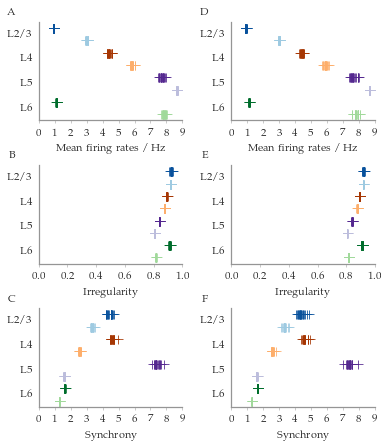

In [9]:
plot_type = 0 # 0, 1, 2, see below
if plot_type == 0:
    plot_data = plot_data_cross
elif plot_type == 1:
    plot_data = plot_data_box
elif plot_type == 2:
    plot_data = plot_data_single

fig = plt.figure()
fig.set_size_inches(style.figsize[0], style.figsize[1]*1.8) 

for i, sli in enumerate([False, True]):
    # DATA
    data_path = "/export/data-schuessler/data_microcircuit/micro"
    sim_spec = "spon_act_statistic"
    if sli:
        sim_spec += "_sli"
    data_file_name  = sim_spec + ".hdf5"  
    res_file_name = sim_spec + "_res.hdf5"
    path_data_file = os.path.join(data_path, data_file_name)
    path_res_file = os.path.join(data_path, res_file_name)

    # # Rates
    ax1 = hf.add_subplot(fig, n_rows_cols=(3, 2), index_row_col=(0, i), rowspan=1, colspan=1)
    data_type="rates_mean"
    xlabel="Mean firing rates / Hz"
    plot_data(ax1, path_res_file, data_type, xlabel, reverse_order)

    # CV of interspike interval (ISI)
    ax2 = hf.add_subplot(fig, n_rows_cols=(3, 2), index_row_col=(1, i), rowspan=1, colspan=1)
    data_type="cv_isi_mean"
    xlabel="Irregularity"
    plot_data(ax2, path_res_file, data_type, xlabel, reverse_order)
    ax2.set_xlim(0, 1)

    # # Synchrony
    ax3 = hf.add_subplot(fig, n_rows_cols=(3, 2), index_row_col=(2, i), rowspan=1, colspan=1)
    data_type="synchrony"
    xlabel="Synchrony"
    plot_data(ax3, path_res_file, data_type, xlabel, reverse_order)
    ax3.set_xlim(0, 9.)

# Label subfigures
plot_labels = list('ABCDEF')
for ax, label in zip(fig.axes, plot_labels):
    ax.text(-0.16, 1.15, label, transform=ax.transAxes,
            fontsize=style.fontsize_labels_title, fontweight='bold', va='top', ha='right')    
    # General rendering
    style.fixticks(ax)
    ax.yaxis.set_ticks_position('none') 
    
fig_name = "spontaneous_activity"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Spike count statistics

This is equivalent to looking more closely behind the distributions shown in the box plot of single neuron firing rates.

The theoretical distributions are those for poisson processes with the corresponding mean rate. 

## Single neuron firing rates

In [2]:
def plot_single_rates(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_rates = np.empty((n_populations, n_spikes_recorded))
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_rates"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_rates[-(i + 1)] = res_grp[population][:]
            else:
                single_rates[i] = res_grp[population][:]

    box_plot(ax, single_rates.T, path_res_file, reverse_order)
    
    ax.set_xlabel("Single neuron firing rates / Hz")

## Single CV of ISIs

In [3]:
def plot_single_CV_ISI(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_cv_isi = [[]] * n_populations
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_cv_isi"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_cv_isi[-(i + 1)] = res_grp[population][:]
                print(population, len(single_cv_isi[-(i + 1)]))
            else:
                single_cv_isi[i] = res_grp[population][:]
                print(population, len(single_cv_isi[i]))
    
    box_plot(ax, single_cv_isi, path_res_file, reverse_order)
    
    ax.set_xlabel('CV of interspike intervals')

/export/data-schuessler/data_microcircuit/micro/spon_act_statistic_res.hdf5
L23e 982
L23i 999
L4e 999
L4i 999
L5e 999
L5i 999
L6e 970
L6i 999


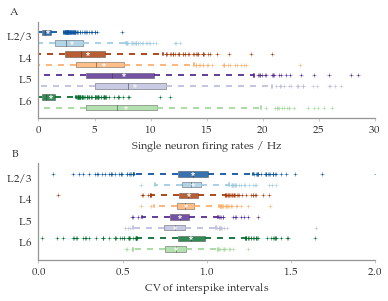

In [7]:
# DATA
fig = plt.figure()
fig.set_size_inches(style.figsize[0], style.figsize[1]*1.2) 
data_path = "/export/data-schuessler/data_microcircuit/micro"
sim_spec = "spon_act_statistic"
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

print(path_res_file)
# Rates
ax1 = hf.add_subplot(fig, n_rows_cols=(2, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_single_rates(ax1, path_res_file, n_spikes_recorded=1000)
# CV of interspike interval (ISI)
ax2 = hf.add_subplot(fig, n_rows_cols=(2, 1), index_row_col=(1, 0), rowspan=1, colspan=1)
plot_single_CV_ISI(ax2, path_res_file, n_spikes_recorded=1000)
ax2.set_xlim(0, 2)

# Label subfigures
plot_labels = list('AB')
for ax, label in zip(fig.axes, plot_labels):
    ax.text(-0.06, 1.15, label, transform=ax.transAxes,
            fontsize=style.fontsize_labels_title, fontweight='bold', va='top', ha='right')    
    # General rendering
    style.fixticks(ax)
    ax.yaxis.set_ticks_position('none') 

fig_name = "single_neuron_activity"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Spike count histogram

In [9]:
data_path = "/export/data-schuessler/data_microcircuit/micro"
sim_spec = "spon_act_statistic_sli"
data_file_name  = sim_spec + ".hdf5" 
path_data_file = os.path.join(data_path, data_file_name)
res_file_name  = sim_spec + "_res.hdf5" 
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    res_grp = res_file["0"]
    rates_mean  = res_grp["rates_mean"][:]
    
n_bins         = 2000
bins           = np.arange(0, n_bins)
hist_n_spikes  = np.zeros((n_populations, n_bins))           
    
with h5py.File(path_data_file, "r") as  data_file:
    grp = data_file["0/spikes"]

    for i, population in enumerate(populations):
        subgrp = grp[str(population)]
        raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
        indices         = subgrp["rec_neuron_i"][:]

        n_spikes_total = np.zeros(len(indices) - 1)
        for j in range(len(indices) - 1):
            times = raw_times_all[indices[j]:indices[j+1]]
            times = times[times > t_trans]      
            n_spikes_total[j] = len(times)

        hist_n_spikes[i] = np.histogram(n_spikes_total, bins=n_bins, 
                                         range=(0, n_bins), density=False)[0]

<n>	var[n]	fano
 52.89	2817.05	 53.26
182.71	15155.80	 82.95
271.20	30501.79	112.47
353.32	46322.55	131.11
454.61	78165.98	171.94
518.09	83841.34	161.83
 67.33	5556.47	 82.53
466.09	70987.59	152.31


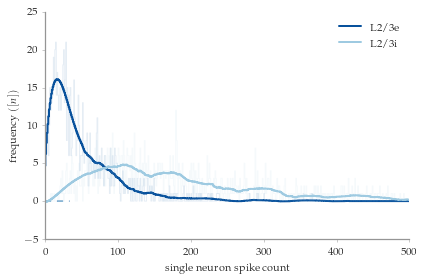

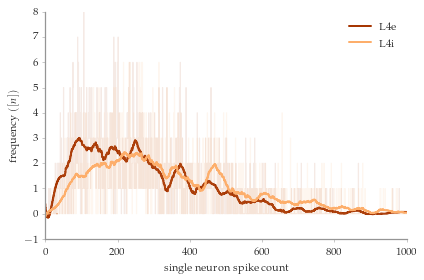

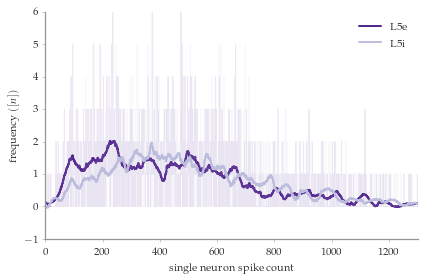

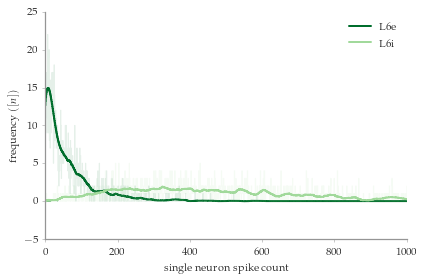

In [18]:
## Theory: P_T[n] = (r * T)**(n) / n! * exp(-r * T)
def P_n_spikes(n, rate, T=t_measure):
    from scipy.misc import factorial
    return (rate * T)**n / factorial(n) * np.exp(-rate * T)
def gauss(n, rate, T=t_measure):
    mu = rate * T
    sigma = np.sqrt(mu)
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (n - mu)**2 / (2 * sigma**2))

from scipy.signal import savgol_filter as sav

xupper = [500, 1000, 1300, 1000]

print("<n>\tvar[n]\tfano")
for l, layer in enumerate(layers):
    fig = plt.figure()

    ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    x_max = 0
    for i, population in enumerate(populations):
        if population.startswith(layer):
            # shift bins by one such that the 0th one is shown
            hist_n_spikes_with_zero = np.zeros(hist_n_spikes[i].shape) 
            hist_n_spikes_with_zero[1:] = hist_n_spikes[i][:-1]
            hist_n_spikes_with_zero[0] = hist_n_spikes_with_zero[1] # duplicate the 1st bin
            
            ax.plot(bins, hist_n_spikes[i], # / np.sum(hist_n_spikes[i]), 
                     linewidth=1., color=colors[i], drawstyle="steps", alpha=0.1)
            
            # Filter hist:
            filter_hist = sav(hist_n_spikes[i], 101, 5, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
            ax.plot(bins, filter_hist, # / np.sum(hist_n_spikes[i]), 
                     linewidth=2., color=colors[i], drawstyle="steps", label=hf.rlbl(population))
            

            rate = rates_mean[i]            
            mean = rate * t_measure
            var = np.dot(hist_n_spikes[i], bins ** 2) / np.sum(hist_n_spikes[i]) - mean**2
            fano_factor = var / mean
            print("{0:6.2f}\t{1:6.2f}\t{2:6.2f}".format(mean, var, fano_factor))

            # Plot expectations for poisson processes
            ax.plot(bins / t_measure, gauss(bins, rate), "--",
                     linewidth=1., color=colors[i], alpha=0.99)
        
            
    #ax.set_ylabel('density $([n])$')
    ax.set_ylabel('frequency $([n])$')
    #ax.set_xlabel('single neuron firing rates $r_i$ / Hz')
    ax.set_xlabel('single neuron spike count')
    ax.set_xlim(0, xupper[l])# 1000 / t_measure)
    ax.legend(loc="best")
    style.fixticks(ax)

    fig_name = "spike_count_histo"
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name, verbose=False) 